In [1]:
import pandas as pd

# Load to train data
train = pd.read_csv("train.csv")

# Dataset shape info
print("Dataset Size:", train.shape)
print("\n First 5 rows:")
print(train.head())

# Check Missing value
print("\n Missing values:")
print(train.isnull().sum())

# Target Columns
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Label Distribution
print("\n Label Distribution:")
print(train[labels].sum().sort_values(ascending=False))


Dataset Size: (159571, 8)

 First 5 rows:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

 Missing values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat    

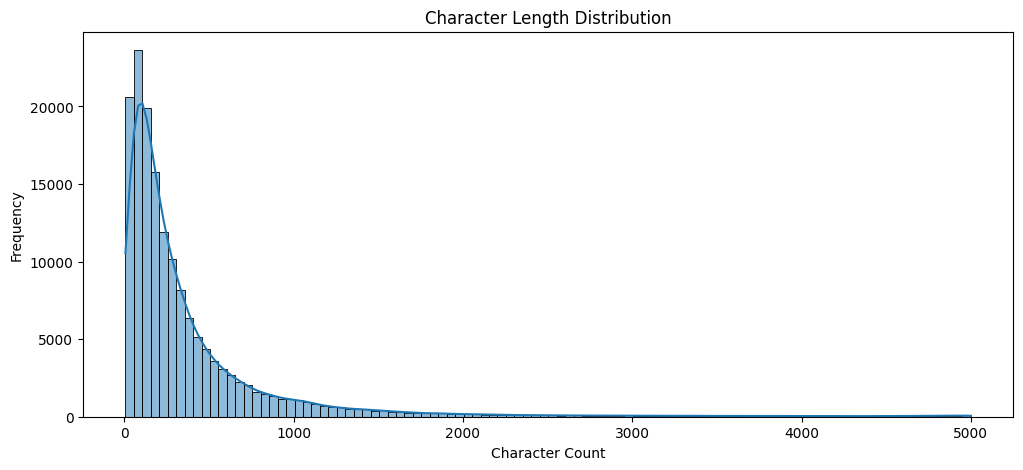

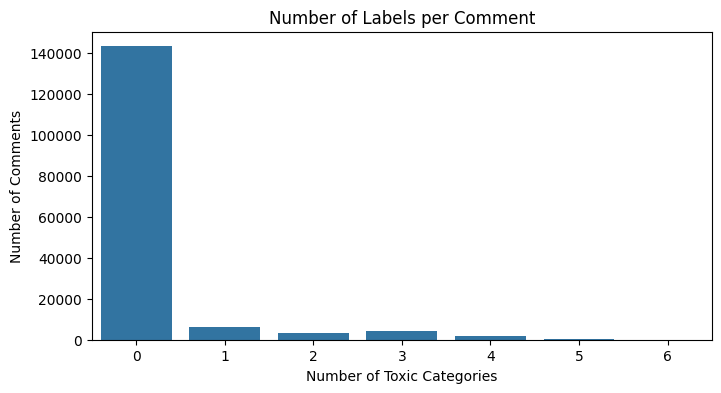

In [2]:
# Comment Lengths & Multiple Tags

import matplotlib.pyplot as plt
import seaborn as sns

# Add comment length features
train['char_length'] = train['comment_text'].apply(len)
train['word_length'] = train['comment_text'].apply(lambda x: len(x.split()))

# Count how many labels each comment has
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['label_sum'] = train[labels].sum(axis=1)

# Plot comment length distribution
plt.figure(figsize=(12, 5))
sns.histplot(train['char_length'], bins=100, kde=True)
plt.title('Character Length Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

# Plot number of labels per comment
plt.figure(figsize=(8, 4))
sns.countplot(x='label_sum', data=train)
plt.title('Number of Labels per Comment')
plt.xlabel('Number of Toxic Categories')
plt.ylabel('Number of Comments')
plt.show()


#### 📏 Character Length Distribution
* Most comments are between 0 and 500 characters.
* In rare cases, long comments can reach up to 5000 characters (probably outliers).
* Very long comments can be normalized or limited during model training (e.g., maxlen=500).

#### 🏷️ Number of Labels per Comment
* Number of comments with 0 labels > 140,000 → most are "clean."
* Comments with 1 label > around 10,000.
* Comments with 2 or more labels are rarer, but important because this competition is multi-label.
* The problem of imbalanced data (class imbalance) is also seen here. To resolve this:

    * class_weight='balanced'    
    * or techniques such as SMOTE or RandomOverSampler can be used.

In [3]:
# Preprocessing

#  Text Cleaning

import re
import string

def clean_text(text):
    """
    Cleans the input text by:
    - Lowercasing
    - Removing URLs, HTML tags, special characters
    - Removing extra whitespace
    """
    text = text.lower()  # convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r"<.*?>", '', text)  # remove HTML tags
    text = re.sub(r"\[.*?\]", '', text)  # remove text in brackets
    text = re.sub(r"[%s]" % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub(r"\n", ' ', text)  # remove newline characters
    text = re.sub(r"\w*\d\w*", '', text)  # remove words with numbers
    text = re.sub(r"\s+", ' ', text).strip()  # remove extra whitespace
    return text

# Apply to train set
train['clean_text'] = train['comment_text'].apply(clean_text)

# Preview cleaned comments
train[['comment_text', 'clean_text']].head()


,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


In [4]:
# Feature Engineering – TF-IDF Vectorization (only with clean_text)

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,2))

# Fit and transform on cleaned comments
X = tfidf.fit_transform(train['clean_text'])

# Target labels
y = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Check shape
print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (159571, 10000)


In [5]:
# Modelling – Logistic Regression (One-vs-Rest)

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifier
logreg = LogisticRegression(solver='saga', max_iter=1000)
model = OneVsRestClassifier(logreg)

# Train the model
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=y.columns))

# ROC-AUC Score (macro average)
roc_auc = roc_auc_score(y_val, y_pred, average='macro')
print(f"Macro ROC-AUC Score: {roc_auc:.4f}")


Classification Report:

               precision    recall  f1-score   support

        toxic       0.90      0.60      0.72      3056
 severe_toxic       0.54      0.21      0.30       321
      obscene       0.91      0.62      0.74      1715
       threat       0.82      0.12      0.21        74
       insult       0.83      0.50      0.62      1614
identity_hate       0.75      0.14      0.23       294

    micro avg       0.88      0.54      0.67      7074
    macro avg       0.79      0.36      0.47      7074
 weighted avg       0.86      0.54      0.66      7074
  samples avg       0.05      0.05      0.05      7074

Macro ROC-AUC Score: 0.6805


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


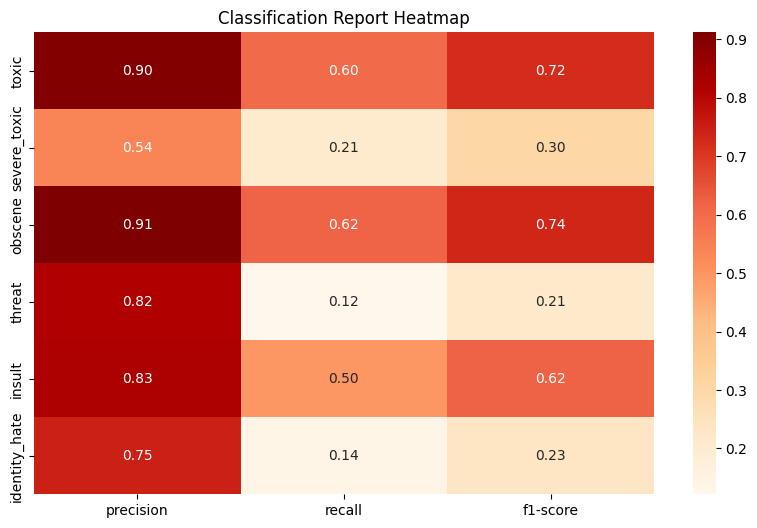

In [6]:
# Visualization with Heatmap

# Only keep label rows
label_metrics = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
report = classification_report(y_val, y_pred, target_names=y.columns, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Select metrics and plot
metrics = report_df.loc[label_metrics, ['precision', 'recall', 'f1-score']]

plt.figure(figsize=(10, 6))
sns.heatmap(metrics, annot=True, fmt=".2f", cmap="OrRd", cbar=True)
plt.title("Classification Report Heatmap")
plt.show()


In [7]:
# Develop the model

# Preaparing Tokenizer and Pad Sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_WORDS = 100000
MAX_LEN = 200  # max sequence length

# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train['clean_text'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(train['clean_text'])

# Pad sequences to uniform length
X_seq = pad_sequences(sequences, maxlen=MAX_LEN)

# Target labels
y = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

print("Shape of X_seq:", X_seq.shape)
print("Shape of y:", y.shape)


Shape of X_seq: (159571, 200)
Shape of y: (159571, 6)


In [8]:
# Multi-label Model base on LSTM

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Parameters
EMBED_DIM = 128

# Define model
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM, input_length=MAX_LEN))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))  # 6 classes, multi-label

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Create Training and Validation Set

from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_seq, y, test_size=0.2, random_state=42)


In [11]:
# Train the model

history = model.fit(
    X_train, y_train,
    epochs=12,
    batch_size=128,
    validation_data=(X_val, y_val)
)


Epoch 1/12
998/998 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8433 - loss: 0.0293 - val_accuracy: 0.9408 - val_loss: 0.0634
Epoch 2/12
998/998 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7096 - loss: 0.0261 - val_accuracy: 0.9314 - val_loss: 0.0711
Epoch 3/12
998/998 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7317 - loss: 0.0232 - val_accuracy: 0.4378 - val_loss: 0.0754
Epoch 4/12
998/998 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6325 - loss: 0.0212 - val_accuracy: 0.7152 - val_loss: 0.0807
Epoch 5/12
998/998 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6033 - loss: 0.0177 - val_accuracy: 0.9231 - val_loss: 0.0840
Epoch 6/12
998/998 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6494 - loss: 0.0168 - val_accuracy: 0.8655 - val_loss: 0.0925
Epoch 7/12
998/998 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5950 - loss: 0.0150 - val_accuracy: 0.9104 - val_loss: 0.1111
Epoch 8/12
998/998 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6154 - loss: 0.0133 - 

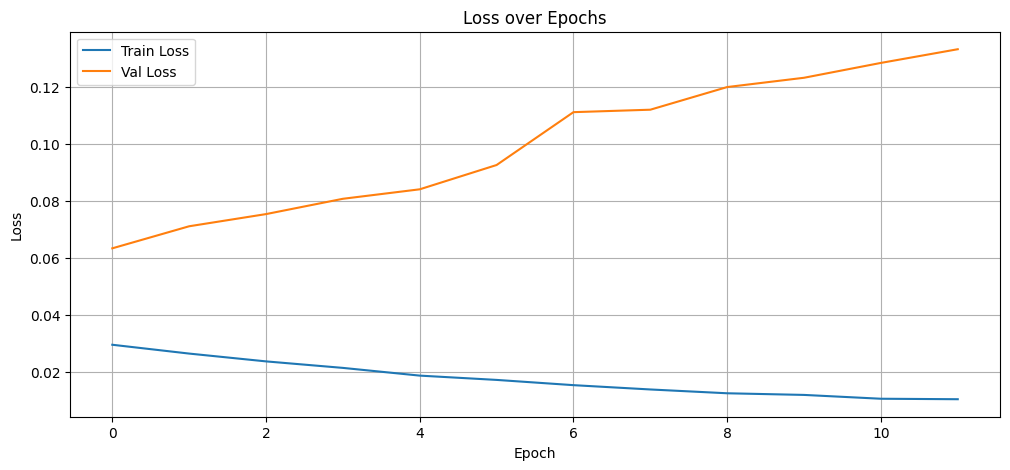

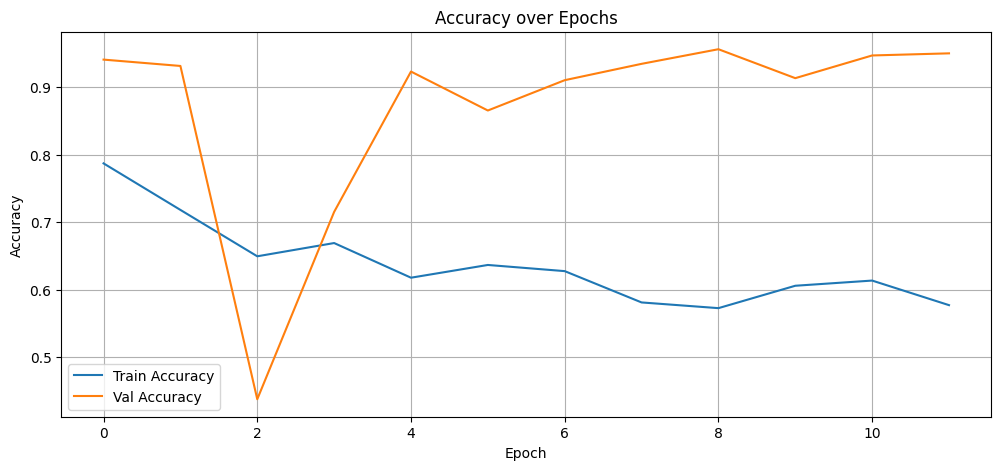

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation accuracy values (sadece bilgi amaçlı)
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Get predict

# Predict probabilities
y_pred_prob = model.predict(X_val)

# Binarize predictions (threshold 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)


998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


In [13]:
# Classification Report + ROC-AUC

from sklearn.metrics import classification_report, roc_auc_score

# Multi-label classification report
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']))

# ROC-AUC Score
roc_auc = roc_auc_score(y_val, y_pred_prob, average='macro')
print(f"Macro ROC-AUC Score: {roc_auc:.4f}")


Classification Report:

               precision    recall  f1-score   support

        toxic       0.75      0.73      0.74      3056
 severe_toxic       0.39      0.45      0.41       321
      obscene       0.81      0.76      0.78      1715
       threat       0.28      0.32      0.30        74
       insult       0.68      0.67      0.68      1614
identity_hate       0.46      0.39      0.42       294

    micro avg       0.71      0.69      0.70      7074
    macro avg       0.56      0.55      0.56      7074
 weighted avg       0.72      0.69      0.70      7074
  samples avg       0.06      0.06      0.06      7074

Macro ROC-AUC Score: 0.9582


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Comparision Results

#### LSTM vs Logistic Regression

| Label         | Logistic F1 | LSTM F1 | Growing         |
| -------------- | ----------- | ------- | ---------------- |
| toxic          | 0.72        | 0.74    | ✅                |
| obscene        | 0.74        | 0.78    | ✅                |
| insult         | 0.62        | 0.68    | ✅                |
| severe\_toxic  | 0.30        | 0.41    | ✅ **big difference** |
| identity\_hate | 0.23        | 0.42    | ✅ **big difference** |
| threat         | 0.21        | 0.30    | ✅                |


Macro ROC-AUC:

Logistic Regression: 0.68

LSTM: 0.96


#### Summary

The LSTM model performed significantly better, especially in classes with fewer examples (threat, identity_hate).

Its sigmoid output structure, suitable for multi-label classification, provided better generalization.

The ROC-AUC score increased significantly.

In [14]:
# Submission preparing

# Clean Test data, convert, padding

# Load test data
test = pd.read_csv("test.csv")

# Clean text
test['clean_text'] = test['comment_text'].apply(clean_text)

# Tokenize and pad
test_seq = tokenizer.texts_to_sequences(test['clean_text'])
X_test = pad_sequences(test_seq, maxlen=MAX_LEN)


In [15]:
# Predict with LSTM Model

# Predict probabilities
test_pred_prob = model.predict(X_test)

# Binarize predictions (threshold = 0.5)
test_pred = (test_pred_prob >= 0.5).astype(int)


4787/4787 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step


In [16]:
# Create submission.csv

# Prepare submission dataframe
submission = pd.DataFrame(test_pred, columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission.insert(0, 'id', test['id'])  # Insert ID column at the beginning

# Save to CSV
submission.to_csv("submission.csv", index=False)


In [18]:
# Save trained model

model.save("lstm_toxic_model.h5")


In [19]:
"""
Save trained tokenizer as pickle so the Streamlit app can reuse it.
Run this once in Colab after training the model.
"""

import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

# replace with the tokenizer variable you trained
# Example assumes `tokenizer` is still in memory
artifact_path = "tokenizer.pkl"

with open(artifact_path, "wb") as f:
    pickle.dump(tokenizer, f)

print(f"Tokenizer saved to {artifact_path}")


Tokenizer saved to tokenizer.pkl
